In [1]:
import hydra
from glob import  glob
from proteoscope.data import ProteoscopeDM
from proteoscope.modules import ProteoscopeLM
import numpy as np
from omegaconf import OmegaConf


BASE_DIR = "/home/ec2-user/outputs/proteoscope/2023-09-03/15-51-52" # Best proteoscope - ESM-full

# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/16-34-38" # 25 x 25 cond latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/22-36-50" # 25 x 25 cond nuclei + latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-05/01-50-26" # 25 x 25 cond nuclei + latent

config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDM(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size // 2,
        num_workers=config.trainer.num_workers,
        trim=config.data.trim,
        sequence_embedding=config.data.sequence_embedding,
        splits=config.splits,
    )
    pdm.setup()

    plm = ProteoscopeLM.load_from_checkpoint(
        chkpt,
        module_config=config.module,
    )

    plm.eval()
    plm.cuda()

/tmp/ipykernel_80122/2795051317.py:16: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs/proteoscope/2023-09-01/20-18-02/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/data/datamodule.py:43: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


## Generate samples

In [3]:
# dl = pdm.custom_dataloader(split_images='val', split_protein='val', shuffle=True)
dl = pdm.custom_dataloader(split_images='val', split_protein='train', shuffle=42)

In [6]:
batch = next(iter(dl))
true_images = batch['image'].detach().cpu().numpy()
batch['image'] = batch['image'].cuda()
batch['sequence_embed'] = batch['sequence_embed'].to('cuda')
batch['sequence_mask'] = batch['sequence_mask'].to('cuda')

In [10]:
predicted_images = []
predicted_latents = []
nis = 40
gs_range = np.linspace(1, 4, 11)

for gs in gs_range:
    predicted_latent = plm.sample(batch, guidance_scale=gs, cond_images=None, num_inference_steps=nis, seed=42)
    predicted_image = plm.autoencoder.decode(predicted_latent).sample
    predicted_images.append(predicted_image.detach().cpu().numpy())
    predicted_latents.append(predicted_latent.detach().cpu().numpy())

predicted_latents = np.stack(predicted_latents)
predicted_images = np.stack(predicted_images)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [20]:
predicted_images = []
predicted_latents = []
# nis_range = np.linspace(20, 100, 7)
nis_range = np.linspace(50, 1000, 5)

gs = 3.0

for nis in nis_range:
    predicted_latent = plm.sample(batch, guidance_scale=gs, cond_images=None, num_inference_steps=int(nis), seed=42)
    predicted_image = plm.autoencoder.decode(predicted_latent).sample
    predicted_images.append(predicted_image.detach().cpu().numpy())
    predicted_latents.append(predicted_latent.detach().cpu().numpy())

predicted_latents = np.stack(predicted_latents)
predicted_images = np.stack(predicted_images)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/762 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
# print(gs_range)
print(nis_range)

[  50.   287.5  525.   762.5 1000. ]


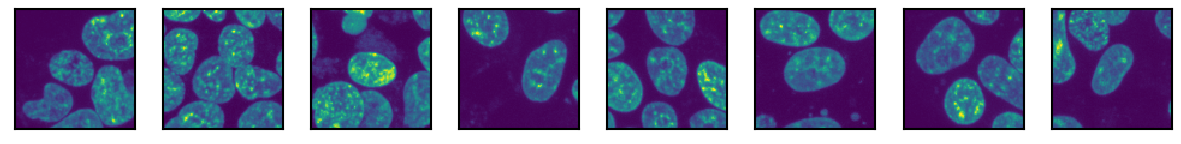

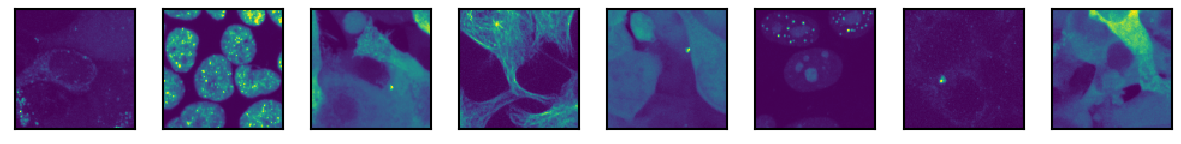

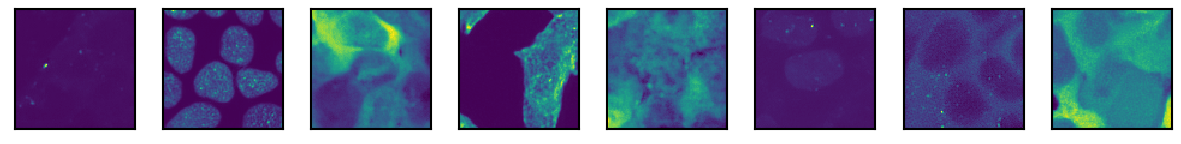

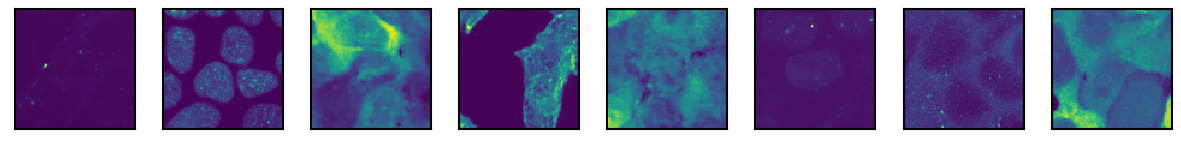

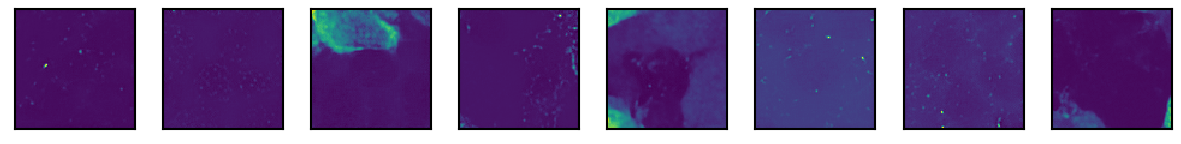

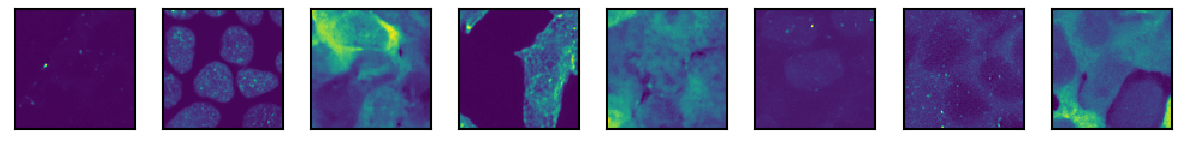

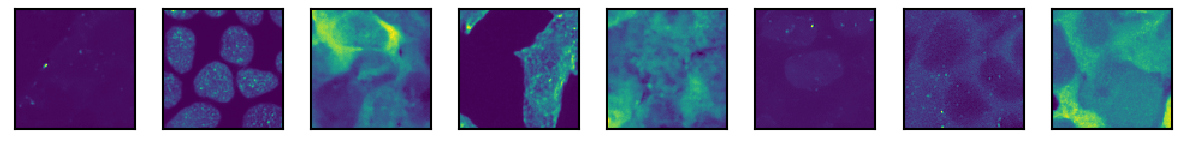

In [23]:
# from proteoscope.plotting import browse_reconstructions, merge_prot_nuc

# browse_reconstructions(true_images[:, 0], predicted_images[2, :, 0])

import seaborn_image as isns


isns.ImageGrid(
    true_images[:, 1], col_wrap=8, cbar=False, height=1.5, axis=0, cmap="viridis"
);

isns.ImageGrid(
    true_images[:, 0], col_wrap=8, cbar=False, height=1.5, axis=0, cmap="viridis"
);

for p_i, gs in zip(predicted_images, gs_range):
    g = isns.ImageGrid(
        p_i[:, 0], col_wrap=8, cbar=False, height=1.5, axis=0, cmap="viridis"
    )

In [34]:
from tqdm import tqdm
import torch

true_images = []
true_localizations = []
predicted_images = []
predicted_latents = []
true_latents = []
true_names = []

# batch = next(iter(dl))
# cond_images_base = batch['image'][0, 1, :, :].unsqueeze(dim=0).unsqueeze(dim=0).cuda()
for _ in range(1):
    for batch in tqdm(dl):
        batch['image'] = batch['image'].cuda()

        predicted_latent = plm.sample(batch, guidance_scale=4.0, cond_images=None, num_inference_steps=400)
        predicted_image = plm.autoencoder.decode(predicted_latent).sample
        true_latent = plm.autoencoder.encode(batch['image']).latent_dist.mean
        
        true_localizations.append(np.array(batch['localization']))

        true_images.append(batch['image'].detach().cpu().numpy())
        true_latents.append(true_latent.detach().cpu().numpy())
        predicted_latents.append(predicted_latent.detach().cpu().numpy())
        predicted_images.append(predicted_image.detach().cpu().numpy())
        true_names.append(batch['name'])

predicted_latents = np.concatenate(predicted_latents, axis=0)
true_images = np.concatenate(true_images, axis=0)
true_localizations = np.concatenate(true_localizations, axis=0)
predicted_images = np.concatenate(predicted_images, axis=0)
true_latents = np.concatenate(true_latents, axis=0)
true_names = np.concatenate(true_names, axis=0)

  0%|          | 0/1328 [00:00<?, ?it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1328 [00:07<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:17                                                                                   │
│                                                                                                  │
│   14 │   for batch in tqdm(dl):                                                                  │
│   15 │   │   batch['image'] = batch['image'].cuda()                                              │
│   16 │   │                                                                                       │
│ ❱ 17 │   │   predicted_latent = plm.sample(batch, guidance_scale=4.0, cond_images=None, num_i    │
│   18 │   │   predicted_image = plm.autoencoder.decode(predicted_latent).sample                   │
│   19 │   │   true_latent = plm.autoencoder.encode(batch['image']).latent_dist.mean               │
│   20                                                                                             │
│                                                                                                  │
│ /home/ec2-user/proteoscope/proteoscope/modules/proteoscope.py:280 in sample                      │
│                                                                                                  │
│   277 │   │   │                                                                                  │
│   278 │   │   │   # predict the noise residual                                                   │
│   279 │   │   │   with torch.no_grad():                                                          │
│ ❱ 280 │   │   │   │   noise_pred = self.unet(                                                    │
│   281 │   │   │   │   │   latent_model_input,                                                    │
│   282 │   │   │   │   │   t,                                                                     │
│   283 │   │   │   │   │   encoder_hidden_states=seq_embeds,                                      │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1190 in           │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1187 │   │   # this function, and just call forward.                                           │
│   1188 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1189 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1190 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1191 │   │   # Do not call functions when jit is used                                          │
│   1192 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1193 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/diffusers/models/unet_2d_condition.py:956 in │
│ forward                                                                                          │
│                                                                                                  │
│   953 │   │   │   │   upsample_size = down_block_res_samples[-1].shape[2:]                       │
│   954 │   │   │                                                                                  │
│   955 │   │   │   if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cro   │
│ ❱ 956 │   │   │   │   sample = upsample_block(                                                   │
│   957 │   │   │   │   │   hidden_states=sample,            

In [32]:
predicted_latents = np.concatenate(predicted_latents, axis=0)
true_images = np.concatenate(true_images, axis=0)
true_localizations = np.concatenate(true_localizations, axis=0)
predicted_images = np.concatenate(predicted_images, axis=0)
true_latents = np.concatenate(true_latents, axis=0)
true_names = np.concatenate(true_names, axis=0)

In [33]:
# np.save('predicted_latents.npy', predicted_latents)
# np.save('true_images.npy', true_images)
# np.save('true_localizations.npy', true_localizations)
# np.save('predicted_images.npy', predicted_images)
# np.save('true_latents.npy', true_latents)
# np.save('true_names.npy', true_names)

In [34]:
# predicted_latents = np.load('predicted_latents.npy')
# true_images = np.load('true_images.npy')
# true_localizations = np.load('true_localizations.npy')
# predicted_images = np.load('predicted_images.npy')
# true_latents = np.load('true_latents.npy')
# true_names = np.load('true_names.npy')

In [35]:
# true_names_avg = np.unique(true_names)
# predicted_latents_avg = []
# true_latents_avg = []

# for name in true_names_avg:
#     keep = true_names == name
#     predicted_latents_avg.append(np.median(predicted_latents[keep], axis=0))
#     true_latents_avg.append(np.median(true_latents[keep], axis=0))
# predicted_latents_avg = np.array(predicted_latents_avg)
# true_latents_avg = np.array(true_latents_avg)

In [36]:
# print(predicted_images.shape)
print(predicted_latents.shape)

(32, 4, 25, 25)


In [37]:
from proteoscope.plotting import browse_reconstructions, merge_prot_nuc


browse_reconstructions(true_images[:, 0], predicted_images[:, 0], true_names)

interactive(children=(Dropdown(description='name', options=('ALG2', 'ANAPC4', 'ARF4', 'CBX1', 'CLK3', 'CSNK1A1…

In [40]:
true_merged = merge_prot_nuc(true_images[:1000], percentiles=[0.1, 99.9])
predicted_merged = merge_prot_nuc(predicted_images[:1000], percentiles=[0.1, 99.9])
true_names_merged = true_names[:1000]

In [41]:
browse_reconstructions(true_merged, predicted_merged, true_names_merged)

interactive(children=(Dropdown(description='name', options=('AMBRA1', 'ANKRD40', 'APPL1', 'ARFGAP2', 'ARHGAP35…

## Cluster scores

In [7]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Generate sample data
n = len(true_names_avg)
Set_A = predicted_latents_avg.reshape(n, -1).copy()
Set_B = true_latents_avg.reshape(n, -1).copy()

# Compute pairwise distances for given pairs
given_pair_dists = np.array([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Compute pairwise distances for random pairs (1000 times)
random_pair_dists = []
np.random.seed(0)
for _ in range(1000):
    np.random.shuffle(Set_B)
    random_pair_dists.extend([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

NameError: name 'true_names_avg' is not defined

In [8]:
# Statistical comparison
_, p_value = mannwhitneyu(given_pair_dists, random_pair_dists)
print(f"P-value: {p_value}")

# Visualization
sns.kdeplot(given_pair_dists, label="Given Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
sns.kdeplot(random_pair_dists, label="Random Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Comparison of Distance Distributions")
plt.show()

NameError: name 'given_pair_dists' is not defined

: 

P-value: 8.877914476564917e-27


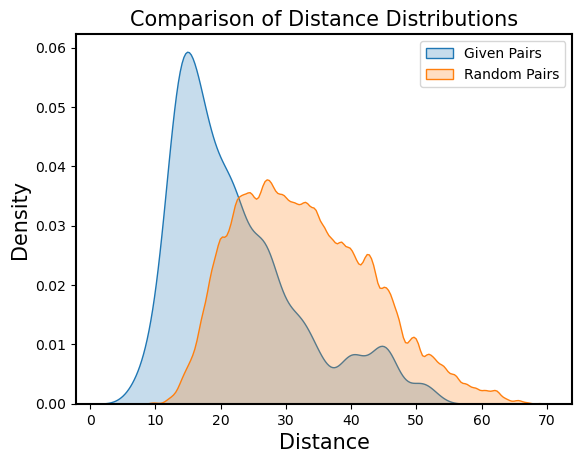

In [14]:
# Statistical comparison
_, p_value = mannwhitneyu(given_pair_dists, random_pair_dists)
print(f"P-value: {p_value}")

# Visualization
sns.kdeplot(given_pair_dists, label="Given Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
sns.kdeplot(random_pair_dists, label="Random Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Comparison of Distance Distributions")
plt.show()

P-value: 4.664245995824613e-121


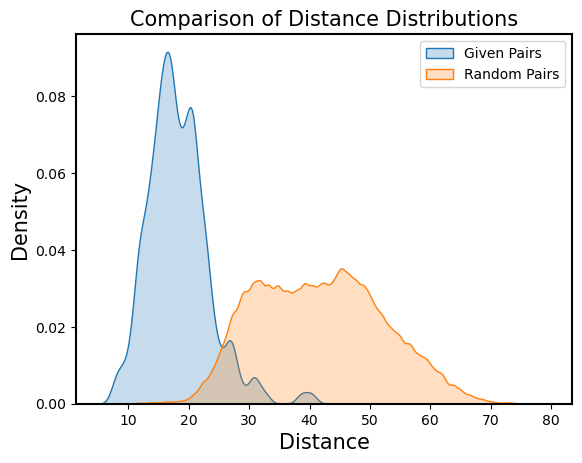

In [14]:
# Statistical comparison
_, p_value = mannwhitneyu(given_pair_dists, random_pair_dists)
print(f"P-value: {p_value}")

# Visualization
sns.kdeplot(given_pair_dists, label="Given Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
sns.kdeplot(random_pair_dists, label="Random Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Comparison of Distance Distributions")
plt.show()

## Umap

In [14]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/autoencoder-data/"
zarr_path = join(datapath, "full_embeddings_2.zarr")

z = zarr.open(zarr_path, mode="r")

In [15]:
labels = pdm.val_images_dataset.labels
latents = z.get_orthogonal_selection(list(labels.index))
latents = latents.reshape(latents.shape[0], -1)

In [16]:
print(latents.max())
print(latents.min())
print(predicted_latents.max())
print(predicted_latents.min())

10.501887321472168
-7.183016777038574
9.402912
-7.1707115


In [17]:
from joblib import load

reducer = load(join(datapath,'umap_model_2a.joblib'))

In [18]:
reduced_latent = reducer.transform(latents)

In [19]:
import seaborn as sns

label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

In [20]:
localizations = np.array(labels['localization'])
localizations[localizations == ''] = 'other'

<AxesSubplot:>

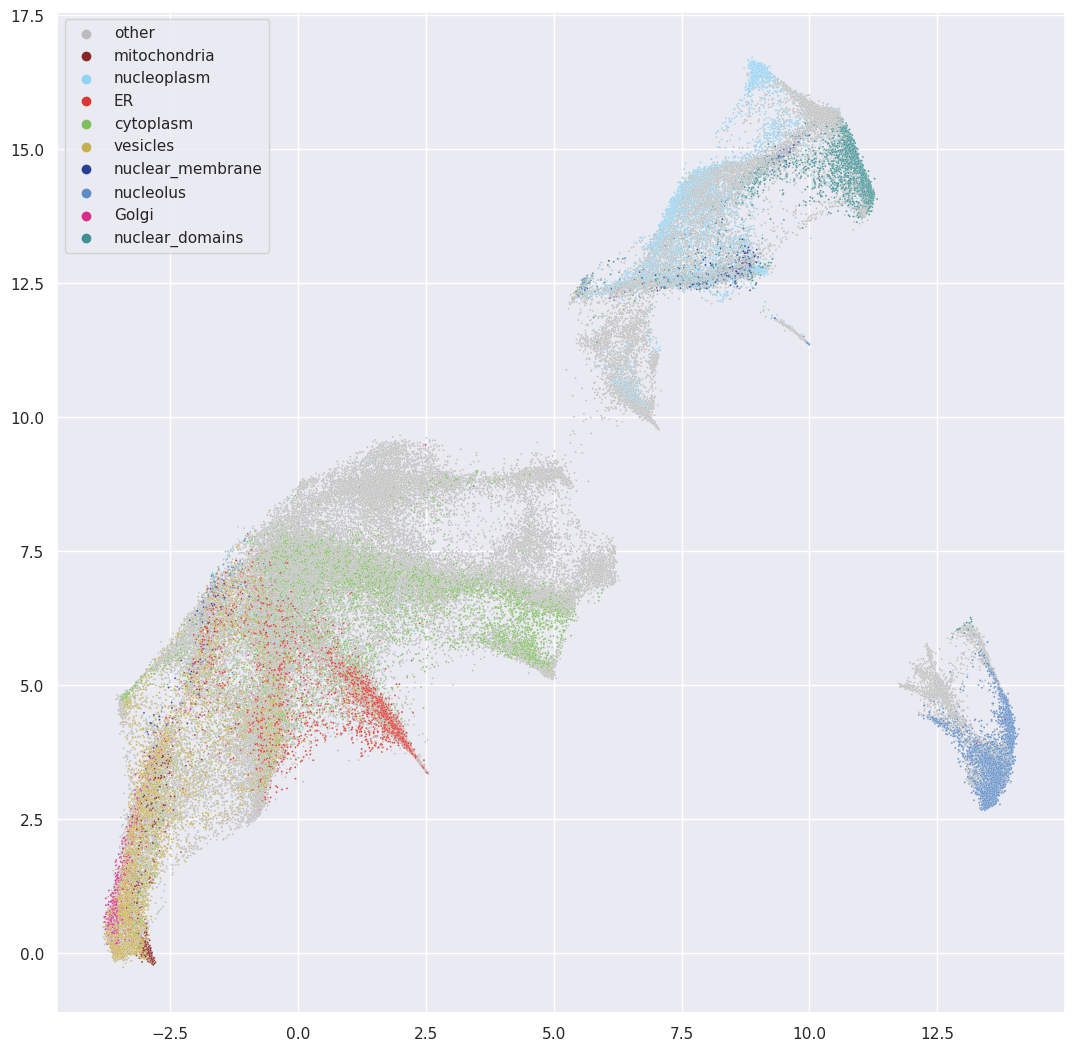

In [21]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_latent[:, 0], y=reduced_latent[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)

In [22]:
predicted_latents = predicted_latents.reshape(predicted_latents.shape[0], -1)

In [23]:
reduced_outputs = reducer.transform(predicted_latents)
reduced_locs = true_localizations

<AxesSubplot:>

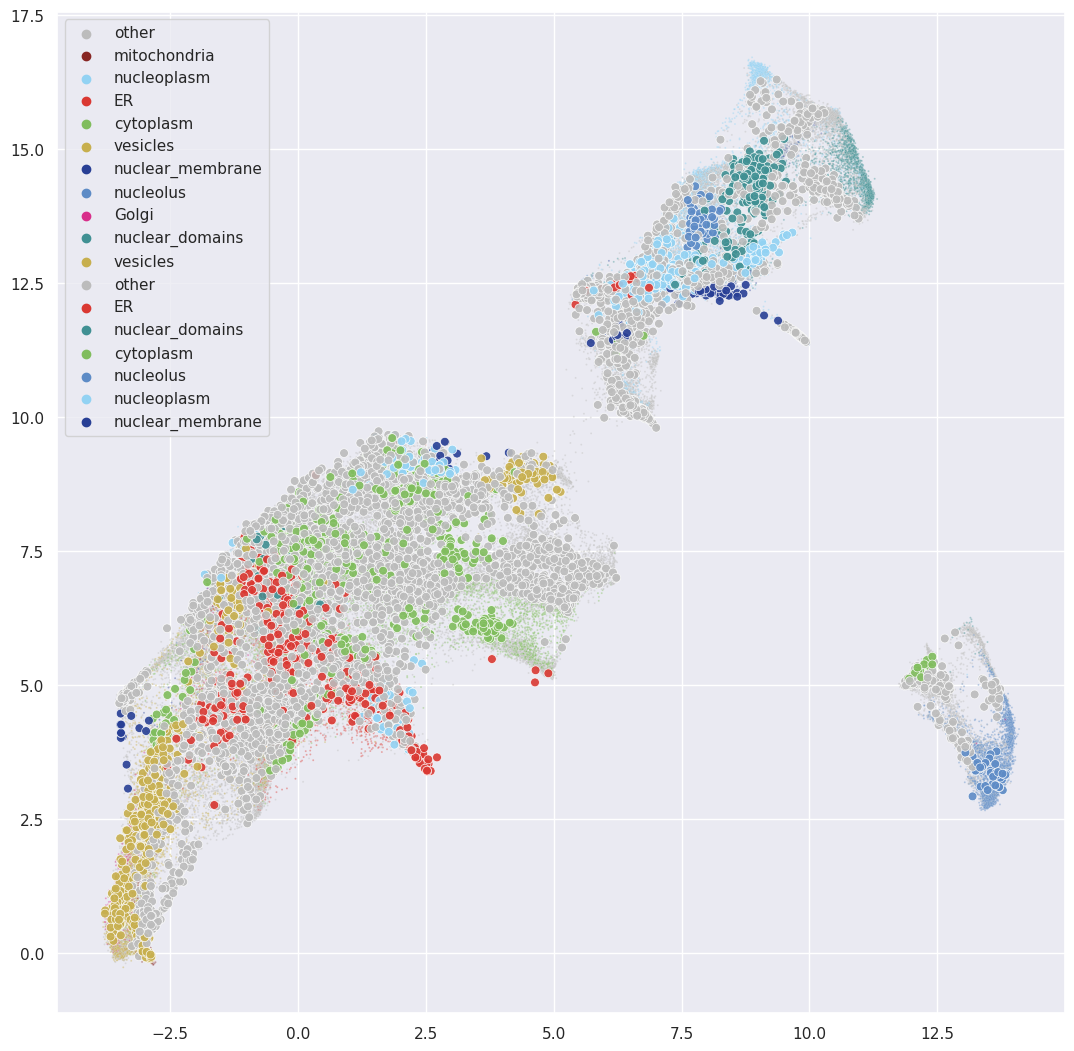

In [24]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_latent[:, 0], y=reduced_latent[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

In [25]:
true_latents = true_latents.reshape(true_latents.shape[0], -1)
reduced_true_outputs = reducer.transform(true_latents)

<AxesSubplot:>

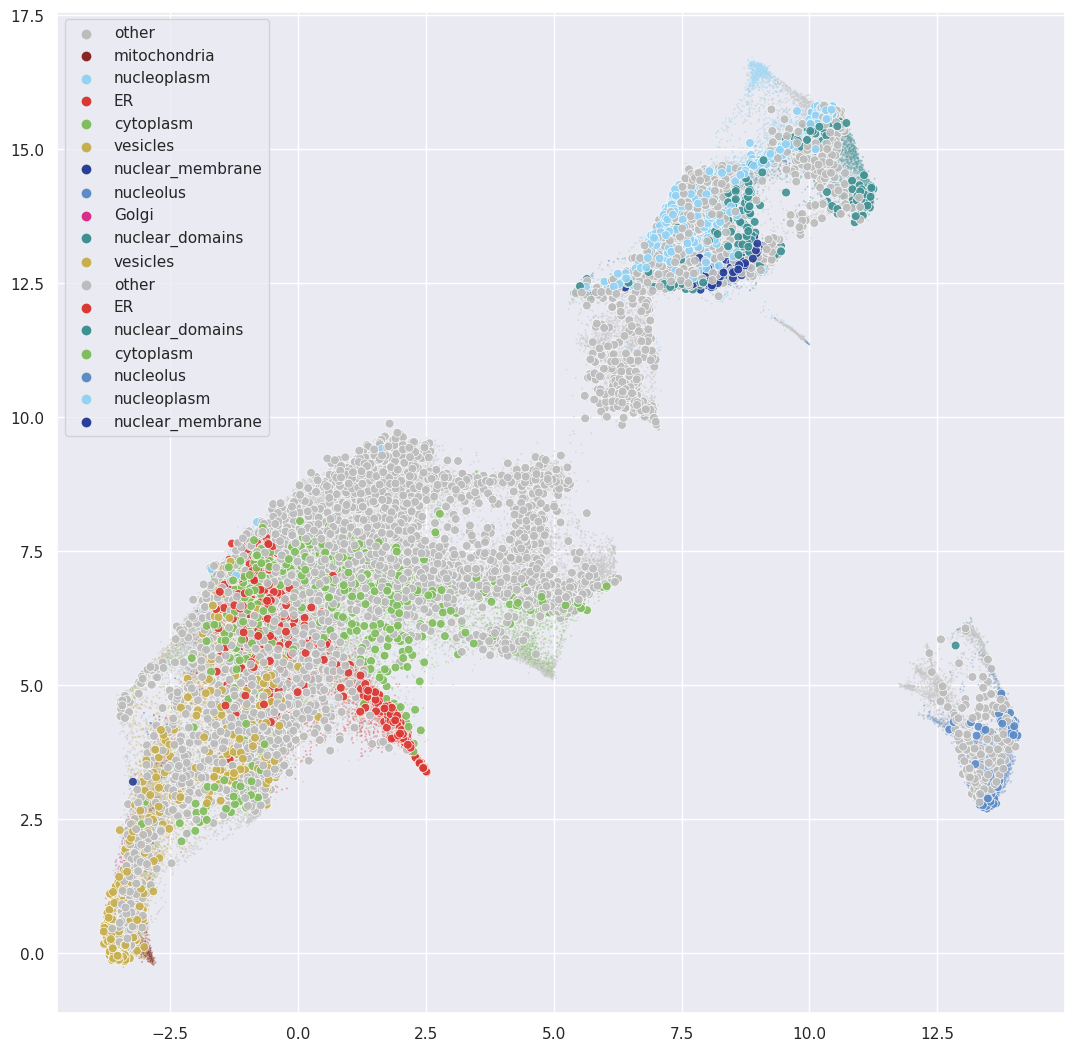

In [26]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_latent[:, 0], y=reduced_latent[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_true_outputs[:, 0], y=reduced_true_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

### Classifications

In [27]:
from joblib import load

# Load the model from the file
clf = load(join(datapath,'localization_classifier_2a.joblib'))


In [36]:
other = true_localizations == 'other'
X_test = predicted_latents[~other]
# X_test = true_latents[~other]
y_test = true_localizations[~other]

In [37]:
true_latents.shape

(7360, 2304)

In [38]:
y_predict = clf.predict(X_test)

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

# class_labels = np.unique(localizations[localizations != 'other'])
class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.6293311845286059


In [40]:
import matplotlib.pyplot as plt

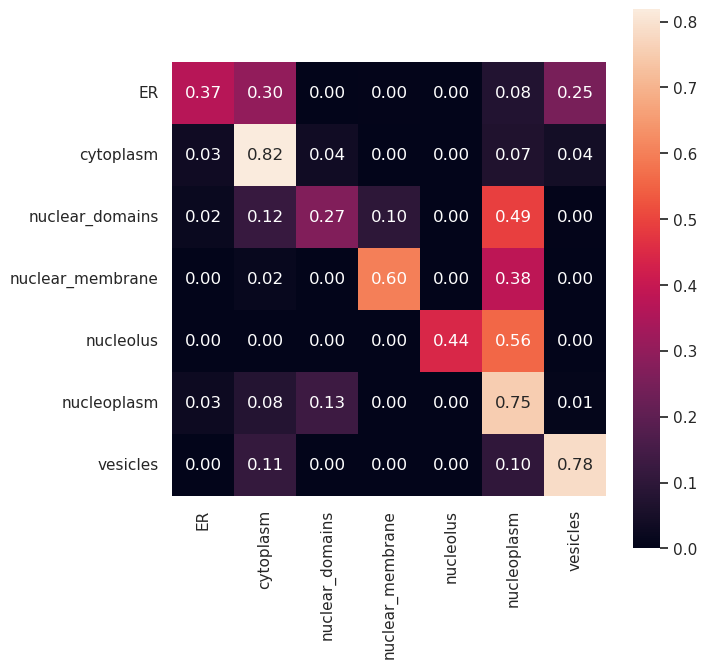

In [41]:
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

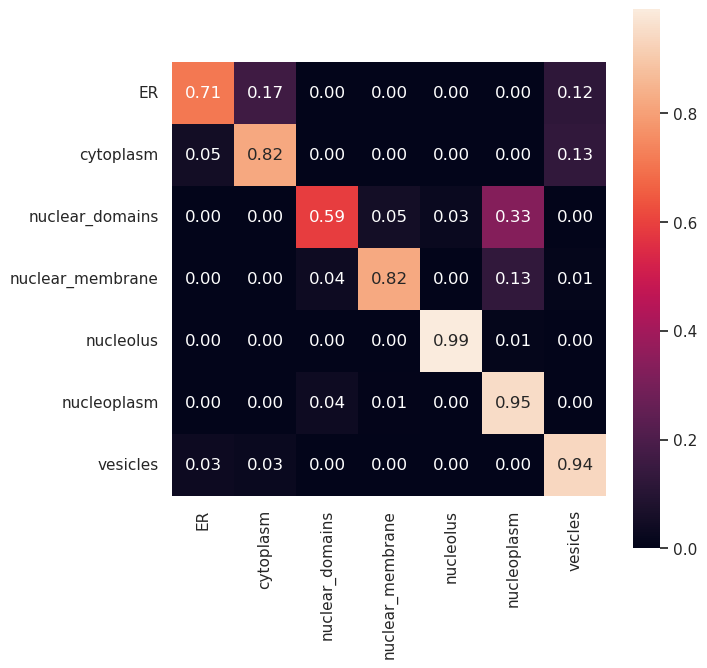

In [35]:
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Latent space position

In [51]:
full_embeddings = np.concatenate([embeddings_train_avg, true_latents_avg])
full_names = np.concatenate([names_train_avg, true_names_avg])

In [52]:
from annoy import AnnoyIndex

f = full_embeddings[0].size  # dimension of the vector
index = AnnoyIndex(f, metric='euclidean')

# Build the index with vectors from A
for i, v in enumerate(full_embeddings.reshape(full_embeddings.shape[0], -1)):
    index.add_item(i, v)
index.build(100)  # 10 trees, can be adjusted based on precision requirements

True

In [53]:
k = 1000
indices_list = []
for v in predicted_latents_avg:
    closest_indices = index.get_nns_by_vector(v.reshape(-1), k)
    indices_list.append(closest_indices)
indices_list = np.array(indices_list)

In [54]:
closest_names = full_names[indices_list]
matches = closest_names == true_names_avg[:, np.newaxis]

In [55]:
matches[:, 0].mean()

0.007633587786259542

In [56]:
scores = []
for j in range(1, matches.shape[1]):
    scores.append(matches[:, :j].any(axis=1).mean())

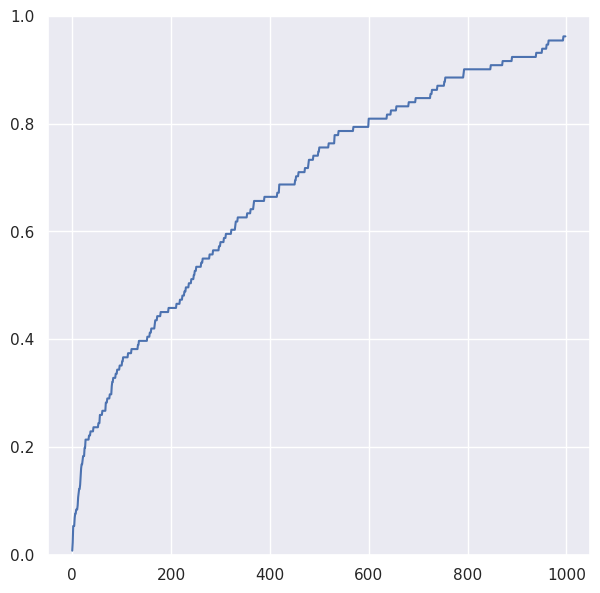

In [57]:
plt.figure(figsize=(7, 7))
plt.plot(scores);
plt.ylim([0, 1]);

In [58]:
old_scores = np.load('1000_full_aa_scores.npy')

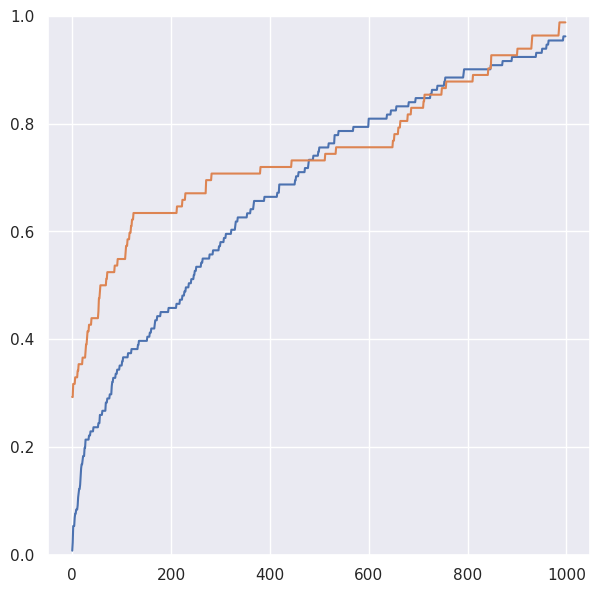

In [59]:
plt.figure(figsize=(7, 7))
plt.plot(scores);
plt.plot(old_scores);
plt.ylim([0, 1]);

In [95]:
# np.save('1000_full_aa_scores.npy', scores)

: 

## ESM localization baseline

In [64]:
pdm.train_dataset.labels = pdm.train_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.train_dataloader()


In [68]:
pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.val_dataloader(novel_proteins=True, shuffle=False)

In [69]:
from tqdm import tqdm
import torch

sequence_embeddings = []
true_localizations = []
for batch in tqdm(dl):    
    true_localizations.append(np.array(batch['localization']))
    sequence_embeddings.append(batch['sequence_embed'].detach().cpu().numpy())

true_localizations = np.concatenate(true_localizations, axis=0)
sequence_embeddings = np.concatenate(sequence_embeddings, axis=0)

100%|██████████| 5/5 [00:00<00:00,  6.03it/s]


In [67]:
embeddings_train = sequence_embeddings[:, 0, :]
localizations_train = true_localizations

In [70]:
embeddings = sequence_embeddings[:, 0, :]
localizations = true_localizations

In [73]:
from sklearn.linear_model import LogisticRegression

other = localizations_train == ''
X_train = embeddings_train[~other]
X_train = X_train.reshape((X_train.shape[0], -1))
y_train = localizations_train[~other]

other = localizations == ''
X_test = embeddings[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = localizations[~other]

In [83]:
np.unique(y_test)

array(['ER', 'cytoplasm', 'nuclear_domains', 'nuclear_membrane',
       'nucleolus', 'nucleoplasm', 'vesicles'], dtype='<U16')

In [78]:
clf = LogisticRegression(random_state=0, penalty='l2', C=1.0).fit(X_train, y_train)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
from joblib import load
from joblib import dump

# Save the model to a file
dump(clf, join(datapath,'localization_classifier_esm.joblib'))

# # Load the model from the file
# clf = load(join(datapath,'localization_classifier_esm.joblib'))


['/home/ec2-user/autoencoder-data/localization_classifier_esm.joblib']

In [80]:
y_predict = clf.predict(X_test)

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.5111111111111111


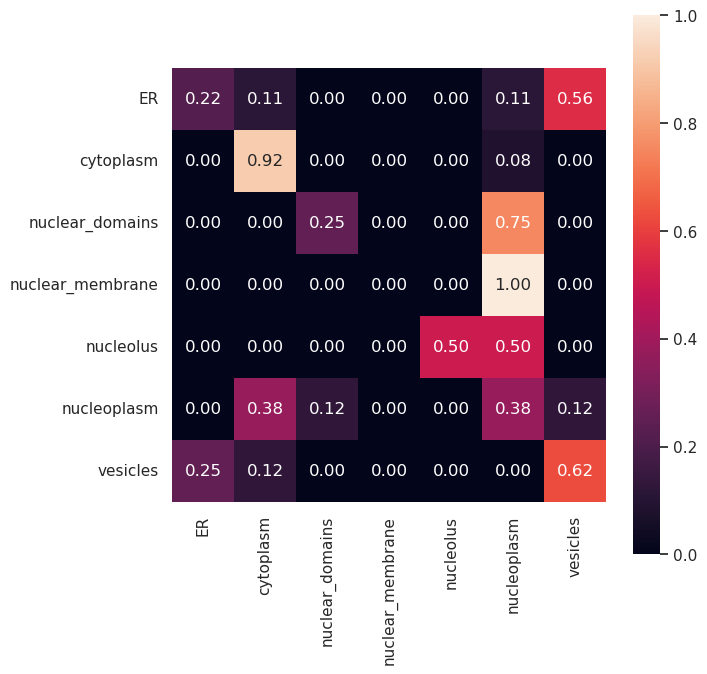

: 

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Combined classification